In [25]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from helper import *

## Load Data 

In [28]:
PATH_TRAIN= '../data/train.csv'
PATH_TEST = '../data/test.csv'
y, tX, ids = load_csv_data(PATH_TRAIN, sub_sample=False)
y_test, tX_test, ids_test = load_csv_data(PATH_TEST, sub_sample=False)
features_name = np.genfromtxt('../data/train.csv', delimiter=",", dtype=str,max_rows=1)[2:]

In [44]:
print("y train size : ", y.shape[0] )
print("train tX shape : ", tX.shape[0])
print( "y test size : ", y_test.shape[0])
print("test tX shape : ", tX_test.shape)

y train size :  250000
train tX shape :  250000
y test size :  568238
test tX shape :  (568238, 30)


In [56]:
np.unique(y)

array(['b', 's'], dtype='<U1')

In [59]:
print("# Higgs signal particules (s): ", len(y[y=='s']), '/',round(len(y[y=='s'])*100/len(y),0),'%')
print("# background particules (b): ", len(y[y=='b']), '/',round(len(y[y=='b'])*100/len(y),0),'%')

# Higgs signal particules (s):  85667 / 34.0 %
# background particules (b):  164333 / 66.0 %


In [54]:
print("There are" , len(tX[tX==-999.0]),'(',
      np.round(len(tX[tX==-999.0])*100./(len(tX)*30)),  "%), missing values")

There are 1580052 ( 21.0 %), missing values


In [60]:
print(features_name)

['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_num'
 'PRI_jet_leading_pt' 'PRI_jet_leading_eta' 'PRI_jet_leading_phi'
 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi'
 'PRI_jet_all_pt']


In [61]:
#plot library
import seaborn as sns
import matplotlib.pyplot as plt

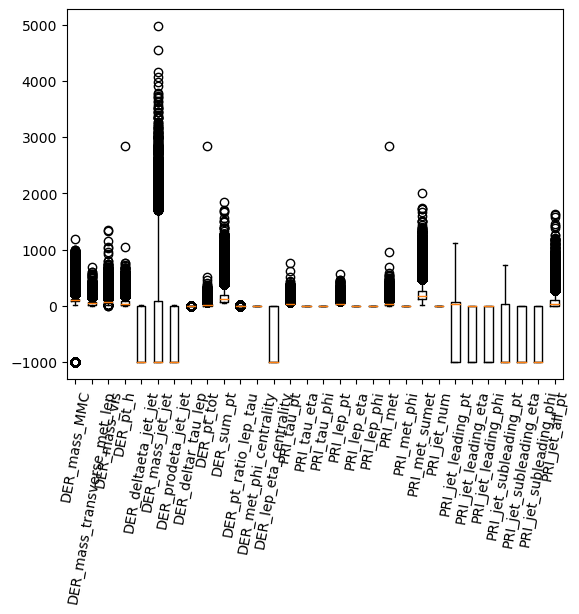

In [70]:
plt.boxplot(x=tX, labels = features_name)
plt.xticks(rotation=80)
plt.show()